# Variational Quantum Linear Solver - ising

⚠ 该方法受启发于 QUBO & Ising-model，作为 [标准VALA方法](./submit.ipynb) 的补充替代方案。  

- 要点：把方程的解强行用二进制离散化表示，以缩小解的搜索空间；转为一般 qubo 问题加以求解
- 优点
  - 可以精确求解有 **整数解** 的方程，或者解值能被 2 的幂的和表达的情况
  - 结果编码在测量后的比特串上，适用于未来的真机测量情况
- 缺点
  - 需要提前知道解的最大取值，以确定编码解时所用量子比特的数量
  - 所需编码的比特数较多

### Step 1: 前处理：实数解方程组转为布尔解方程组

将解向量中每个元素 $ x_i $ 用二进制串表达后，确定其搜索的解空间为 BasisEncode 所规定的空间。即将原整系数方程组 $ A x = b $

$$
\begin{array}{ll}
\begin{bmatrix}
   2 &  5 & -13 \\
   3 & -9 &   3 \\
  -5 &  6 &   8 \\
\end{bmatrix} \begin{bmatrix}
  12 \\
  5 \\
  3 \\
\end{bmatrix} = \begin{bmatrix}
  10 \\
  0 \\
  -6 \\
\end{bmatrix}
\end{array}
$$

保持右边不变，转换为整系数方程组 $ A_s x_s = b $

$$
\begin{array}{ll}
\begin{bmatrix}
\begin{array}{cccc|ccc|cc}
   16 &   8 &   4 &  2 &  20 &  10 &  5 & -26 & -13 \\
   24 &  12 &   6 &  3 & -36 & -18 & -9 &   6 &   3 \\
  -40 & -20 & -10 & -5 &  24 &  12 &  6 &  16 &   8 \\
\end{array}
\end{bmatrix}
\begin{bmatrix}
  1 \\ 1 \\ 0 \\ 0 \\ 
  \hline
  1 \\ 0 \\ 1 \\ 
  \hline
  1 \\ 1 \\
\end{bmatrix} = \begin{bmatrix}
  10 \\
  \hline
  0 \\
  \hline
  -6 \\
\end{bmatrix}
\end{array}
$$

其中新解 $ x_s $ 是原解 $ x $ 的二进制表达 (注意此处的划线示意**并非**分块矩阵)

In [18]:
import numpy as np
from sympy import Symbol

S = lambda x: Symbol(x, real=True)

Am = np.asarray([
  [ 2,  5, -13],
  [ 3, -9,   3],
  [-5,  6,   8],
])
bv = np.asarray([[10, 0, -6]]).T
xv = np.asarray([[12, 5, 3]]).T

# x1 = 12 < 16, basis-encode as |b14,b13,b12,b11>
# x2 = 5 < 8, basis-encode as |b23,b22,b21>
# x3 = 3 < 4, basis-encode as |b32,b31>
x1 = 8 * S('b14') + 4 * S('b13') + 2 * S('b12') + 1 * S('b11')
x2 =                4 * S('b23') + 2 * S('b22') + 1 * S('b21')
x3 =                               2 * S('b32') + 1 * S('b31')

print('decompose solution element x_i to bit string:')
x = [x1, x2, x3]
x = [it.simplify() for it in x]
for i, it in enumerate(x):
  print(f'x{i}:', it)
print()

print('reformat left-hand of the equation A @ x:')
Ax = Am @ x
Ax = [it.simplify() for it in Ax]
for i, it in enumerate(Ax):
  print(f'Ax{i}:', it)
print()

# 新方程的变量 (约束到bool类型)
vars = [
  S('b14'), S('b13'), S('b12'), S('b11'),   # x1, 4-qubits
  S('b23'), S('b22'), S('b21'),             # x2, 3-qubits
  S('b32'), S('b31'),                       # x3, 2-qubits
]
# 构造新方程组：3个方程，9个变量
As = np.asarray([
  [Ax[0].coeff(v) for v in vars],
  [Ax[1].coeff(v) for v in vars],
  [Ax[2].coeff(v) for v in vars],
], dtype=np.int32)
print('[As]')
print(As)

# 新方程的真实解
dec_to_bits = lambda x: [int(e) for e in bin(x)[2:]]
xs = np.concatenate([dec_to_bits(e) for e in xv.flatten()], axis=0)
print('[xs]')
print(xs)

# 验证转换是无损的
assert np.allclose(As @ xs, bv.flatten())

decompose solution element x_i to bit string:
x0: b11 + 2*b12 + 4*b13 + 8*b14
x1: b21 + 2*b22 + 4*b23
x2: b31 + 2*b32

reformat left-hand of the equation A @ x:
Ax0: 2*b11 + 4*b12 + 8*b13 + 16*b14 + 5*b21 + 10*b22 + 20*b23 - 13*b31 - 26*b32
Ax1: 3*b11 + 6*b12 + 12*b13 + 24*b14 - 9*b21 - 18*b22 - 36*b23 + 3*b31 + 6*b32
Ax2: -5*b11 - 10*b12 - 20*b13 - 40*b14 + 6*b21 + 12*b22 + 24*b23 + 8*b31 + 16*b32

[As]
[[ 16   8   4   2  20  10   5 -26 -13]
 [ 24  12   6   3 -36 -18  -9   6   3]
 [-40 -20 -10  -5  24  12   6  16   8]]
[xs]
[1 1 0 0 1 0 1 1 1]


### Step 2: VQE 过程

⚪ 哈密顿量参考 [QUBO, Ising Hamiltonians and VQA](https://quantumcomputing.stackexchange.com/questions/14098/qubo-ising-hamiltonians-and-vqa) 和 [How to convert QUBO problem to Ising Hamiltonian?](https://quantumcomputing.stackexchange.com/questions/11663/how-to-convert-qubo-problem-to-ising-hamiltonian/11665#11665) 给出

In [19]:
from typing import List, Tuple
from spinqit import generate_hamiltonian_matrix

# variable to qubit mapping
n_qubits = len(vars)
H_I = np.identity(2**n_qubits)
var_to_x = {var: S(f'x{i}') for i, var in enumerate(vars)}

# 构造损失函数, 每行方程左端都应该等于右端
print('[Loss Function]')
fx_list = []
for i in range(len(As)):
  # mse_loss = (Ax-b)**2/2，转为二次型
  fx = (sum(coeff * var_to_x[vars[i]] for i, coeff in enumerate(As[i])) - bv[i].item())**2 / 2
  print(f'f(x)_{i}:', fx)
  fx_list.append(fx)
fx = sum(fx_list).expand()
print('f(x):', fx)
assert fx.subs({S(f'x{i}'): x for i, x in enumerate(xs)}) == 0, 'should be 0 at the solution point :)'

# QUBO to Ising: xi -> (1 - zi) / 2, zi^2 -> 1
fz = fx.subs({S(f'x{i}'): (1 - S(f'z{i}')) / 2 for i in range(n_qubits)}).expand()
fz = fz.subs({S(f'z{i}')**2: 1 for i in range(n_qubits)}).expand()
print('f(z):', fz)
print()

# build Ising-hamiltonian
terms: List[Tuple[str, float]] = [
  # the const term
  ('I' * n_qubits, float(fz.subs({S(f'z{i}'): 0.0 for i in range(n_qubits)}))),
]
for i in range(n_qubits):   # terms with one Zi
  coeff = float(fz.coeff(S(f'z{i}')).subs({S(f'z{i}'): 0.0 for i in range(n_qubits)}))
  string = ''.join([('Z' if k == i else 'I') for k in range(n_qubits)])
  terms.append((string, coeff))
for i in range(n_qubits):   # terms with two ZiZj
  for j in range(n_qubits):
    if i > j: continue
    coeff = float(fz.coeff(S(f'z{i}') * S(f'z{j}')))
    string = ''.join([('Z' if k in [i, j] else 'I') for k in range(n_qubits)])
    terms.append((string, coeff))
H = generate_hamiltonian_matrix(terms).todense().real

print('[Hamiltonian] shape:', H.shape)
D = np.diag(H)
print(D)   # H is diagonal :)
E0 = np.min(D)
print('min. diag(H):', E0)
loc = np.where(np.diag(H) == E0)[0].item()
print('solution loc:', loc, ', bits:', bin(loc)[2:])

[Loss Function]
f(x)_0: (16*x0 + 8*x1 + 4*x2 + 2*x3 + 20*x4 + 10*x5 + 5*x6 - 26*x7 - 13*x8 - 10)**2/2
f(x)_1: (24*x0 + 12*x1 + 6*x2 + 3*x3 - 36*x4 - 18*x5 - 9*x6 + 6*x7 + 3*x8)**2/2
f(x)_2: (-40*x0 - 20*x1 - 10*x2 - 5*x3 + 24*x4 + 12*x5 + 6*x6 + 16*x7 + 8*x8 + 6)**2/2
f(x): 1216*x0**2 + 1216*x0*x1 + 608*x0*x2 + 304*x0*x3 - 1504*x0*x4 - 752*x0*x5 - 376*x0*x6 - 912*x0*x7 - 456*x0*x8 - 400*x0 + 304*x1**2 + 304*x1*x2 + 152*x1*x3 - 752*x1*x4 - 376*x1*x5 - 188*x1*x6 - 456*x1*x7 - 228*x1*x8 - 200*x1 + 76*x2**2 + 76*x2*x3 - 376*x2*x4 - 188*x2*x5 - 94*x2*x6 - 228*x2*x7 - 114*x2*x8 - 100*x2 + 19*x3**2 - 188*x3*x4 - 94*x3*x5 - 47*x3*x6 - 114*x3*x7 - 57*x3*x8 - 50*x3 + 1136*x4**2 + 1136*x4*x5 + 568*x4*x6 - 352*x4*x7 - 176*x4*x8 - 56*x4 + 284*x5**2 + 284*x5*x6 - 176*x5*x7 - 88*x5*x8 - 28*x5 + 71*x6**2 - 88*x6*x7 - 44*x6*x8 - 14*x6 + 484*x7**2 + 484*x7*x8 + 356*x7 + 121*x8**2 + 178*x8 + 68
f(z): 304*z0*z1 + 152*z0*z2 + 76*z0*z3 - 376*z0*z4 - 188*z0*z5 - 94*z0*z6 - 228*z0*z7 - 114*z0*z8 + 60*z0 + 76*

⚪ 由于解空间为 BasisEncode 空间, 含参线路设计为无纠缠的 RY 门阵列，参数初始化为 $ \pi / 2 $

[Ansatz]


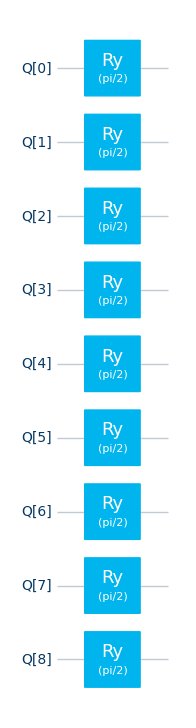

In [20]:
from spinqit import Circuit, Ry
from spinqit.view import draw
from spinqit import get_compiler

print('[Ansatz]')
circ = Circuit()
qv = circ.allocateQubits(n_qubits)
for i in range(n_qubits):
  circ << (Ry, qv[i], np.pi / 2)
compiler = get_compiler('native')
ir = compiler.compile(circ, level=0)
draw(ir)

⚪ 参数优化

这里使用 SpinQit 来实现

Optimize: step 1, loss: 943.4999999897684, time: 0.03231096267700195s
Optimize: step 2, loss: 947.3734448395705, time: 0.03265118598937988s
Optimize: step 3, loss: 920.2316454100298, time: 0.030366897583007812s
Optimize: step 4, loss: 916.8528702002633, time: 0.021988391876220703s
Optimize: step 5, loss: 895.5138514677438, time: 0.03153252601623535s
Optimize: step 6, loss: 846.4371681328737, time: 0.03306770324707031s
Optimize: step 7, loss: 779.9578621186255, time: 0.034173011779785156s
Optimize: step 8, loss: 705.4031566730557, time: 0.05027151107788086s
Optimize: step 9, loss: 629.7794038723745, time: 0.03491377830505371s
Optimize: step 10, loss: 559.4128133219035, time: 0.03321242332458496s
Optimize: step 11, loss: 501.58504441329774, time: 0.031565189361572266s
Optimize: step 12, loss: 459.0816548078734, time: 0.032288551330566406s
Optimize: step 13, loss: 427.1116929033202, time: 0.0344233512878418s
Optimize: step 14, loss: 402.8486013171166, time: 0.03395271301269531s
Optimize: 

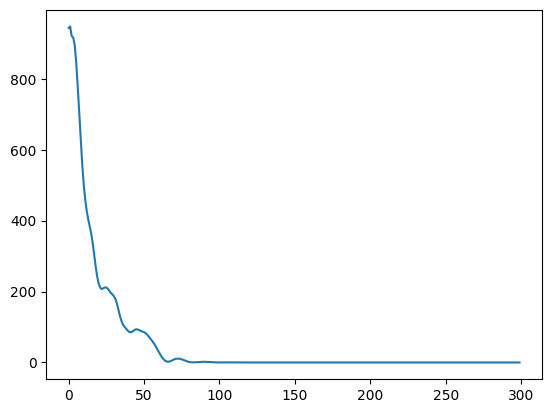

In [21]:
from scipy.sparse import csr_matrix
from spinqit.algorithm import VQE
from spinqit.algorithm.optimizer import ADAM
import matplotlib.pyplot as plt

''' HParam '''
lr = 0.2
iters = 300
seed = 1024
np.random.seed(seed)

''' Hamiltonian '''
ham = csr_matrix(H)

''' Ansatz '''
param_shape = (n_qubits,)
circ = Circuit()
qv = circ.allocateQubits(n_qubits)
p = circ.add_params(shape=param_shape)
for i in range(n_qubits):
  circ << (Ry, qv[i], p[i])

''' Train '''
optim = ADAM(maxiter=iters, learning_rate=lr, tolerance=1e-30, verbose=True)
vqe = VQE(ham, optim, ansatz=circ, params=np.ones(param_shape) * (np.pi / 2))
loss_list = vqe.run(mode='spinq', grad_method='param_shift')
print()
print('>> optimized params:', vqe.optimized_params)

''' Plot '''
losses = [it.item() for it in loss_list]
plt.plot(losses, label='loss')

### Step 3: 运行训练好的线路

借助量子退火的概念，训练后的 RY 门参数取值应为 0 或 $ \pi $，故实际测量时用 X 门取代

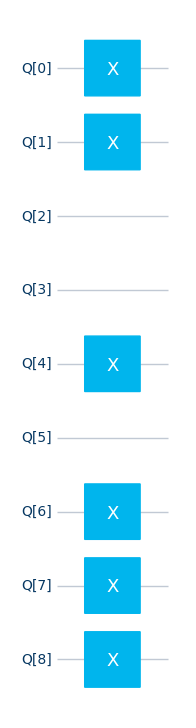

In [22]:
from spinqit import X
from spinqit import get_compiler

circ = Circuit()
qv = circ.allocateQubits(n_qubits)
p = vqe.optimized_params
for i in range(n_qubits):
  # replace RY to I / X after training
  if np.isclose(p[i] % (2*np.pi), np.pi):
    circ << (X, qv[i])
compiler = get_compiler('native')
ir = compiler.compile(circ, level=0)
draw(ir)

presented keys: ['110010111']
[Theoretical Results]
state: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

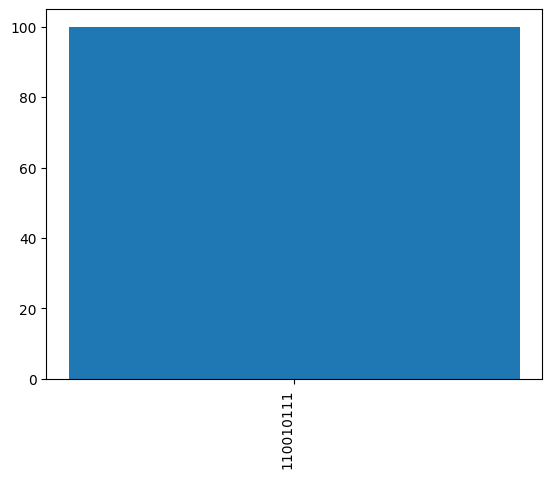

In [23]:
from spinqit import get_basic_simulator, BasicSimulatorConfig
import matplotlib.pyplot as plt

shots = 100

engine = get_basic_simulator()
config = BasicSimulatorConfig()
config.configure_shots(shots)
result = engine.execute(ir, config)

keys = sorted(result.probabilities.keys())
print('presented keys:', keys)
state = [it.real for it in result.states]
probs = [result.probabilities.get(key, 0.0) for key in keys]
print('[Theoretical Results]')
print('state:', state)
print('probs:', probs)
counts = [result.counts.get(key, 0) for key in keys]
freqs = [result.counts.get(key, 0) / shots for key in keys]
print('[Practical Results]')
print('counts:', counts)
print('freqs:', freqs)

plt.bar(keys, counts)
plt.xticks(rotation=90, ha='right')
plt.show()

### Step 4: 后处理

从测量比特串读出代数解

In [24]:
from collections import Counter
bits = Counter(result.counts).most_common()[0][0]
print('bits:', bits)

x1 = int(bits[:4], base=2)
x2 = int(bits[4:7], base=2)
x3 = int(bits[7:], base=2)
print('solution:', [x1, x2, x3])

bits: 110010111
solution: [12, 5, 3]
